In [39]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import scipy as sp
from scipy.stats import norm
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Pregunta 1

**Un portafolio de inversión consiste de 1000 acciones de Microsoft. Use el enfoque paramétrico para estimar el riesgo del portafolio a través del VaR y el ES . Compare los resultados cuando se emplean los métodos siguientes para calcular la volatilidad: el estimador clásico insesgado, el estimador EWMA y el estimador GARCH.**

Primero se cargan los datos se convierte a un objeto tipo serie de tiempo.

<Axes: xlabel='Date'>

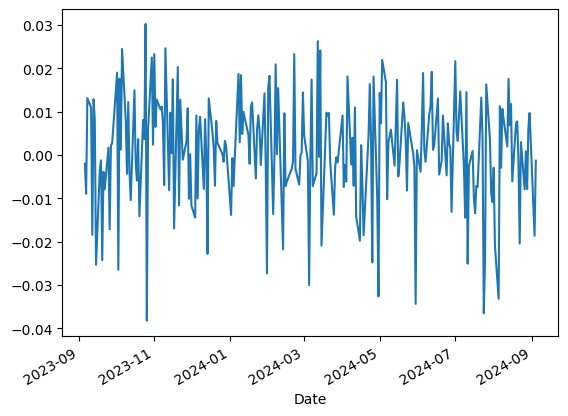

In [40]:
MSFT = pd.read_csv("/Users/ester/Desktop/CA0417 Riesgos en Entidades Financieras I/MSFT.csv")

MSFT["Date"]=pd.to_datetime(MSFT["Date"])

MSFT = pd.Series(data = MSFT["Adj Close"].values, index = MSFT["Date"])



from statsmodels.tsa.stattools import adfuller
dftest = adfuller(MSFT, regression = "c", autolag = "AIC")
dftest

MSFT = np.log(MSFT).diff().dropna()

# Ventana de volatilidad 30 días: PREGUNTARS
# dMSFT.rolling(30).std().plot()

MSFT.plot()

## Estimador usual

Ahora se va a calcular el estimador insesgado de volatilidad que viene dado por

$$ \hat{\sigma}^2 = \frac{1}{n-1} \sum^{n}_{i=1} (X_{i} - \overline{X})^2 $$

In [41]:
mu = MSFT.mean()
sigma_cuadrado = 1/(len(MSFT)-1)*np.sum((MSFT-mu)**2)
sigma = np.sqrt(sigma_cuadrado)

print("Sigma = ", sigma)

Sigma =  0.0125761553273009


Ahora se puede calcular el VaR como 
$$VaR = \mu + \sigma \cdot z_{\alpha}$$
donde $\mu$ es la media, $\sigma$ la varianza y $z_{\alpha}$ el cuantil $\alpha$.

In [42]:
VaR = mu + sigma*norm.ppf(0.95)
print("VaR = ", VaR*1000)

VaR =  21.527193173078615


Mientras que para el ES bajo el supuesto de normalidad de los rendimientos se tiene que:

$$
    ES = \mu + \sigma \cdot \frac{e^{-\frac{z_\alpha^2}{2}}}{(1-\alpha)\sqrt{2\pi}}
$$
De esta manera el $ES$ es:

In [43]:
ES = mu + sigma * np.exp(-norm.ppf(0.95)**2 / 2) / ((1 - 0.95) * np.sqrt(2 * np.pi))
print("ES = ", ES*1000)

ES =  26.782255132688963


## EWMA

Ahora se va a calcular el estimador EWMA con ponderador histórico $\lambda = 0.95$ dado por:

$$
\hat{\sigma}^2 = \frac{1-\lambda}{1-\lambda^n} \sum^n_{i=1} \lambda^{i-1} (X_i-\overline{X})^2 
$$

In [44]:
lambda_ = 0.95
n = len(MSFT)

# Calcular varianza EWMA
lambdas = np.array([lambda_**i for i in range(n)])
suma_ponderada = np.sum(lambdas * (MSFT - mu)**2)
sigma_cuadrado_ewma = (1 - lambda_) / (1 - lambda_**n) * weighted_sum
sigma_ewma = np.sqrt(sigma_cuadrado_ewma)

print("Sigma EWMA =", sigma_ewma)

Sigma EWMA = 0.013421955186929005


Con este nuevo estimador de la volatilidad se vuelven a calcular el VaR y el ES como se describió anteriormente

In [45]:
VaR_ewma = mu + sigma_ewma * norm.ppf(0.95)
ES_ewma = mu + sigma_ewma * np.exp(-norm.ppf(0.95)**2 / 2) / ((1 - 0.95) * np.sqrt(2 * np.pi))


print("VaR EWMA =", VaR_ewma * 1000)
print("ES EWMA =", ES_ewma * 1000)

VaR EWMA = 22.91841013986295
ES EWMA = 28.52689733573184


## GARCH(1,1)

Bajo el modelo GARCH(1,1) se utiliza como estimador de la volatilidad:

$$
    \sigma_{t+1}^2= \omega+\alpha X^2_{t} + \beta \sigma^2_{t}
$$

donde $\omega = \gamma V_L$, $V_L$ es la varianza promedio de largo plazo y $\gamma, \alpha$ y $\beta$ párametros tales que $\gamma + \alpha + \beta = 1$. Como no se tienen datos sobre los párametros a utilizar se aplicará una función para ajustarla en Python.

In [46]:
model = arch_model(MSFT, vol='Garch', p=1, q=1)
model_fit = model.fit()

volatilidad_garch = model_fit.conditional_volatility
sigma_garch = volatilidad_garch.iloc[-1]
print("Sigma GARCH =", sigma_garch)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4345251.265176601
Iteration:      2,   Func. Count:     17,   Neg. LLF: -38.35391525479989
Iteration:      3,   Func. Count:     26,   Neg. LLF: -742.7037534566879
Iteration:      4,   Func. Count:     32,   Neg. LLF: -742.8763181002
Iteration:      5,   Func. Count:     37,   Neg. LLF: -742.8819619034932
Iteration:      6,   Func. Count:     42,   Neg. LLF: -742.8827275696844
Iteration:      7,   Func. Count:     47,   Neg. LLF: -742.8828346366399
Iteration:      8,   Func. Count:     52,   Neg. LLF: -742.8831212591747
Iteration:      9,   Func. Count:     57,   Neg. LLF: -742.8832663590583
Iteration:     10,   Func. Count:     62,   Neg. LLF: -742.8833166940667
Iteration:     11,   Func. Count:     67,   Neg. LLF: -742.8833146646783
Optimization terminated successfully    (Exit mode 0)
            Current function value: -742.8833167398936
            Iterations: 11
            Function evaluations: 68
            Gradient evaluat

In [49]:
VaR_garch = mu + sigma_garch * norm.ppf(0.95)
ES_garch = mu + sigma_garch * np.exp(-norm.ppf(0.95)**2 / 2) / ((1 - 0.95) * np.sqrt(2 * np.pi))

print("VaR GARCH =", VaR_garch * 1000)
print("ES GARCH =", ES_garch * 1000)

VaR GARCH = 21.9036711895971
ES GARCH = 27.254373753880166


# Pregunta 2

**Repita el ejercicio anterior si, además de las acciones de Microsoft, se tienen 2550 acciones de NVidia.**

In [52]:
NVDA = pd.read_csv("/Users/ester/Desktop/CA0417 Riesgos en Entidades Financieras I/NVDA.csv")

NVDA["Date"] = pd.to_datetime(NVDA["Date"])

NVDA = pd.Series(data=NVDA["Adj Close"].values, index=NVDA["Date"])

NVDA = np.log(NVDA).diff().dropna()

retornos = pd.DataFrame({
    'MSFT': MSFT,
    'NVDA': NVDA
}).dropna()

In [63]:
pesos = np.array([1000, 2550])

# Calcular la matriz de covarianza
cov_matrix = retornos.cov()

# Media de los retornos del portafolio
port_mu = retornos.mean().dot(pesos) / np.sum(pesos)

# Volatilidad del portafolio usando la fórmula de varianza del portafolio
port_variance = np.dot(pesos.T, np.dot(cov_matrix, pesos)) / np.sum(pesos)**2
port_volatility = np.sqrt(port_variance)

print("Volatilidad del Portafolio =", port_volatility)


Volatilidad del Portafolio = 0.024393211033778135


In [64]:
z = norm.ppf(0.95)

VaR = (port_mean + port_volatility * z)
ES = (port_mean + port_volatility * np.exp(-z**2 / 2) / ((1 - 0.95) * np.sqrt(2 * np.pi)))

print("VaR del Portafolio =", VaR * (1000+2550))  
print("ES del Portafolio =", ES * (1000+2550)) 

VaR del Portafolio = 152.58232420169645
ES del Portafolio = 188.76721566834203


## EWMA

In [72]:
portafolio = retornos.dot(pesos) / np.sum(pesos)
mu = portafolio.mean()
n = len(port_returns)

# Calcular varianza EWMA
lambdas = np.array([lambda_**i for i in range(n)])
suma_ponderada = np.sum(lambdas * (portafolio - mu)**2)
sigma_cuadrado = (1 - lambda_) / (1 - lambda_**n) * suma_ponderada
sigma_ewma = np.sqrt(sigma_cuadrado)

print("Sigma EWMA = ", sigma_ewma)

Sigma EWMA =  0.0180535261393802


In [73]:
VaR_ewma = (mu + sigma_ewma * z)
ES_ewma = (mu + sigma_ewma * np.exp(-z**2 / 2) / ((1 - 0.95) * np.sqrt(2 * np.pi)))

print("VaR EWMA del Portafolio =", VaR_ewma * (1000+2550))  
print("ES EWMA del Portafolio =", ES_ewma * (1000+2550))  

VaR EWMA del Portafolio = 115.56344359410278
ES EWMA del Portafolio = 142.3440459116543


## GARCH(1,1)

In [80]:
model_garch = arch_model(port_returns, vol='Garch', p=1, q=1)
model_fit_garch = model_garch.fit(disp="off")

vol_garch = model_fit_garch.conditional_volatility
sigma_garch = vol_garch.iloc[-1]

print("Sigma GARCH", sigma_garch)

Sigma GARCH 0.028297719151955045


In [82]:
VaR_garch = (mu + sigma_garch * z)
ES_garch = (mu + sigma_garch * np.exp(-z**2 / 2) / ((1 - 0.95) * np.sqrt(2 * np.pi)))

print("VaR GARCH =", VaR_garch * (1000+2550))  
print("ES GARCH =", ES_garch * (1000+2550))    

VaR GARCH = 175.38164660743536
ES GARCH = 217.35848577179186
